# Bag of Visual Words

From https://www.pinecone.io/learn/series/image-search/bag-of-visual-words/ with polished code

In [1]:
from src.phishIRISData import PhishIRISDataset
from src.config import config
from sklearn.model_selection import train_test_split
from src.helpers import compute_accuracy, visualize

from src.SIFT_bovw import (
    read_bw_images,
    sift_features,
    get_visual_words,
    get_frequency_vectors,
    get_tfidf,
    search_test,
)

import joblib

In [2]:
train_dataset = PhishIRISDataset(
    data_dir=config.PHISHIRIS_DL_DATASET_DIR, split="train", preprocess=False
)
val_dataset = PhishIRISDataset(
    data_dir=config.PHISHIRIS_DL_DATASET_DIR, split="val", preprocess=False
)

In [3]:
k, codebook = joblib.load(config.PROCESSED_DATA_DIR / "bovw-codebook.pkl")

## Train

In [10]:
images_training, images_testing, labels_training, labels_testing = train_test_split(
    train_dataset.img_paths, train_dataset.labels, test_size=0.2, random_state=42
)

bw_images_train, bw_images_test = (
    read_bw_images(images_training),
    read_bw_images(images_testing),
)

In [11]:
# keypoints_train, descriptors_train = sift_features(bw_images_train)
# keypoints_test, descriptors_test = sift_features(bw_images_test)
#
# joblib.dump(descriptors_train, config.PROCESSED_DATA_DIR / "bovw-train.pkl")
# joblib.dump(descriptors_test, config.PROCESSED_DATA_DIR / "bovw-test.pkl")

descriptors_train = joblib.load(config.PROCESSED_DATA_DIR / "bovw-train.pkl")
descriptors_test = joblib.load(config.PROCESSED_DATA_DIR / "bovw-test.pkl")

visual_words_train = get_visual_words(descriptors_train, codebook)
visual_words_test = get_visual_words(descriptors_test, codebook)

In [20]:
frequency_vectors_train = get_frequency_vectors(visual_words_train, k)
frequency_vectors_test = get_frequency_vectors(visual_words_test, k)

In [21]:
tfidf_train = get_tfidf(frequency_vectors_train)
tfidf_test = get_tfidf(frequency_vectors_test)

df.shape, df[:5]: (200,), [706 958 884 633 882]
idf.shape, idf[:5]: (200,), [0.39693021 0.09169767 0.17208838 0.50607502 0.17435339]
df.shape, df[:5]: (200,), [178 244 231 147 227]
idf.shape, idf[:5]: (200,), [0.39037048 0.07498581 0.12973632 0.58172145 0.14720401]


In [22]:
search_test(tfidf_test[0], tfidf_train)

(array([538, 489,  33,  81, 290]),
 array([0.98449263, 0.94872002, 0.89343473, 0.80111785, 0.75056325]))

In [25]:
print(labels_testing[0])
for idx, el in enumerate([538, 489, 33, 81, 290]):
    print(f"{idx}: {labels_training[el]}")

chase
0: chase
1: chase
2: chase
3: chase
4: dropbox


In [26]:
k1, d1 = sift_features([bw_images_test[15]])
vw1 = get_visual_words(d1, codebook)
fv1 = get_frequency_vectors(vw1, k)

len before: 1
indexes: []
len after: 1


In [28]:
import matplotlib.pyplot as plt

plt.bar(list(range(k)), fv1[0])
plt.show()

NameError: name 'fv1' is not defined

In [ ]:
search_test(
    fv1[0], tfidf_train, search_image=bw_images_test[15], db_images=bw_images_train
)

In [30]:
labels_training[55], labels_testing[15]

('facebook', 'facebook')

## Evaluation

In [4]:
bw_train_images = read_bw_images(train_dataset.img_paths)
bw_val_images = read_bw_images(val_dataset.img_paths)

In [5]:
keypoints_train, descriptors_train = sift_features(bw_train_images)
keypoints_val, descriptors_val = sift_features(bw_val_images)

len before: 1313
indexes: []
len after: 1313
len before: 1539
indexes: []
len after: 1539


In [7]:
# joblib.dump(descriptors_train, config.PROCESSED_DATA_DIR / "bovw-train.pkl")
# joblib.dump(descriptors_val, config.PROCESSED_DATA_DIR / "bovw-val.pkl")

descriptors_train = joblib.load(config.PROCESSED_DATA_DIR / "bovw-train.pkl")
descriptors_val = joblib.load(config.PROCESSED_DATA_DIR / "bovw-val.pkl")

visual_words_train = get_visual_words(descriptors_train, codebook)
visual_words_val = get_visual_words(descriptors_val, codebook)

In [8]:
frequency_vectors_train = get_frequency_vectors(visual_words_train, k)
frequency_vectors_val = get_frequency_vectors(visual_words_val, k)

In [9]:
tfidf_train = get_tfidf(frequency_vectors_train)
# tfidf_val = get_tfidf(frequency_vectors_val)

df.shape, df[:5]: (200,), [706 958 884 633 882]
idf.shape, idf[:5]: (200,), [0.39693021 0.09169767 0.17208838 0.50607502 0.17435339]


In [14]:
y_pred = []
y_conf = []
y_true = []

for idx, (X, label) in enumerate(val_dataset):
    indexes, confidence_scores = search_test(
        get_tfidf(frequency_vectors_train + frequency_vectors_val[idx])[-1],
        tfidf_train,
        top_k=1,
    )
    _, pred_label = train_dataset[indexes[0]]
    y_pred.append(pred_label)
    y_conf.append(confidence_scores[0])
    y_true.append(label)

compute_accuracy(y_true, y_pred)

df.shape, df[:5]: (200,), [1050 1050 1050 1050 1050]
idf.shape, idf[:5]: (200,), [0. 0. 0. 0. 0.]
df.shape, df[:5]: (200,), [ 706 1050 1050  633 1050]
idf.shape, idf[:5]: (200,), [0.39693021 0.         0.         0.50607502 0.        ]
df.shape, df[:5]: (200,), [1050 1050 1050 1050 1050]
idf.shape, idf[:5]: (200,), [0. 0. 0. 0. 0.]
df.shape, df[:5]: (200,), [1050 1050 1050  633  882]
idf.shape, idf[:5]: (200,), [0.         0.         0.         0.50607502 0.17435339]
df.shape, df[:5]: (200,), [1050 1050 1050 1050 1050]
idf.shape, idf[:5]: (200,), [0. 0. 0. 0. 0.]
df.shape, df[:5]: (200,), [ 706 1050 1050  633 1050]
idf.shape, idf[:5]: (200,), [0.39693021 0.         0.         0.50607502 0.        ]
df.shape, df[:5]: (200,), [1050 1050 1050 1050 1050]
idf.shape, idf[:5]: (200,), [0. 0. 0. 0. 0.]
df.shape, df[:5]: (200,), [ 706 1050 1050  633 1050]
idf.shape, idf[:5]: (200,), [0.39693021 0.         0.         0.50607502 0.        ]
df.shape, df[:5]: (200,), [ 706 1050  884 1050 1050]
idf

(0.147498375568551, 0.05466751556574409)

In [22]:
y_pred = []
y_conf = []
y_true = []

for idx, (X, label) in enumerate(val_dataset):
    indexes, confidence_scores = search_test(
        frequency_vectors_val[idx], tfidf_train, top_k=1
    )
    _, pred_label = train_dataset[indexes[0]]
    y_pred.append(pred_label)
    y_conf.append(confidence_scores[0])
    y_true.append(label)

compute_accuracy(y_true, y_pred)

acc:			26.51072
balanced_acc:	6.06909


(0.2651072124756335, 0.0606908646463782)

In [20]:
# train + frequency vector to tfidf
from sklearn.metrics import classification_report
import numpy as np

print(
    classification_report(
        y_true, y_pred, target_names=np.unique([label for _, label in train_dataset])
    )
)

              precision    recall  f1-score   support

       adobe       0.00      0.00      0.00        27
     alibaba       0.02      0.04      0.03        26
      amazon       0.00      0.00      0.00        11
       apple       0.00      0.07      0.01        15
         boa       0.03      0.23      0.05        35
       chase       0.01      0.03      0.02        37
         dhl       0.00      0.00      0.00        42
     dropbox       0.00      0.00      0.00        40
    facebook       0.02      0.05      0.03        57
    linkedin       0.00      0.00      0.00        14
   microsoft       0.10      0.08      0.09        53
       other       0.63      0.20      0.30      1000
      paypal       0.06      0.06      0.06        93
  wellsfargo       0.04      0.07      0.05        45
       yahoo       0.00      0.00      0.00        44

    accuracy                           0.15      1539
   macro avg       0.06      0.05      0.04      1539
weighted avg       0.42   

/Users/marcinjarczewski/src/phish-target-recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcinjarczewski/src/phish-target-recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcinjarczewski/src/phish-target-recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

In [23]:
# just frequency vector acc 27%
from sklearn.metrics import classification_report
import numpy as np

print(
    classification_report(
        y_true, y_pred, target_names=np.unique([label for _, label in train_dataset])
    )
)

              precision    recall  f1-score   support

       adobe       0.03      0.04      0.03        27
     alibaba       0.02      0.04      0.03        26
      amazon       0.00      0.00      0.00        11
       apple       0.02      0.07      0.03        15
         boa       0.03      0.06      0.04        35
       chase       0.00      0.00      0.00        37
         dhl       0.00      0.00      0.00        42
     dropbox       0.00      0.00      0.00        40
    facebook       0.05      0.12      0.07        57
    linkedin       0.00      0.00      0.00        14
   microsoft       0.01      0.02      0.01        53
       other       0.65      0.38      0.48      1000
      paypal       0.04      0.08      0.06        93
  wellsfargo       0.04      0.11      0.06        45
       yahoo       0.00      0.00      0.00        44

    accuracy                           0.27      1539
   macro avg       0.06      0.06      0.05      1539
weighted avg       0.43   

/Users/marcinjarczewski/src/phish-target-recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcinjarczewski/src/phish-target-recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcinjarczewski/src/phish-target-recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

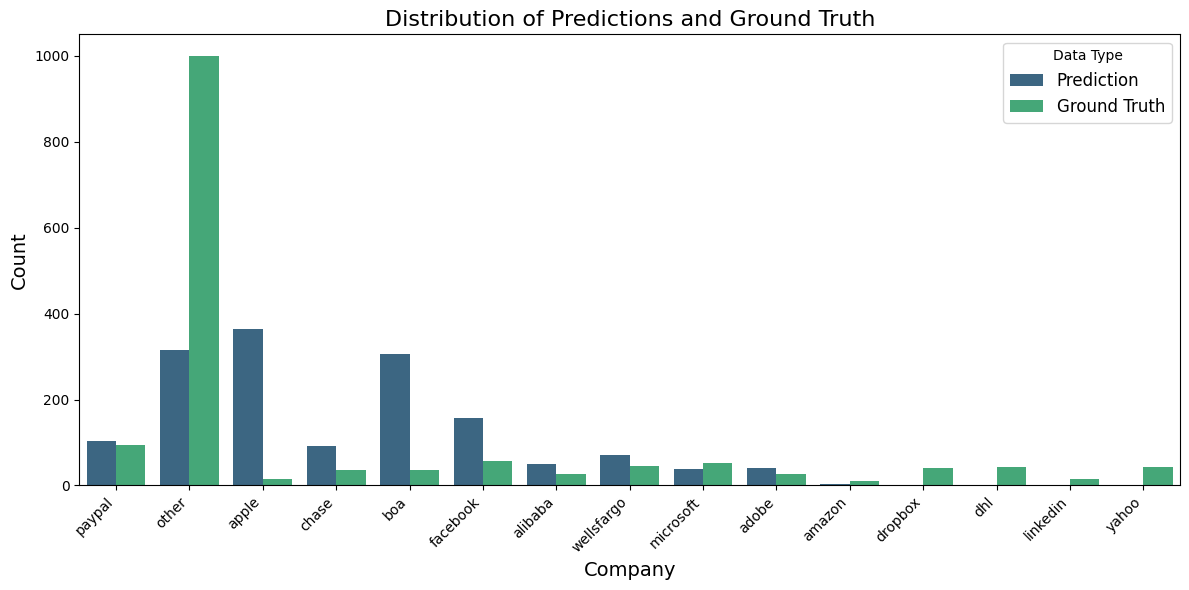

In [15]:
data = visualize(y_true, y_pred)

In [16]:
data[data["Type"] == "Prediction"]["Company"].value_counts()

Company
apple         363
other         316
boa           306
facebook      157
paypal        103
chase          91
wellsfargo     70
alibaba        50
adobe          41
microsoft      39
amazon          3
Name: count, dtype: int64

In [17]:
data[data["Type"] == "Ground Truth"]["Company"].value_counts()

Company
other         1000
paypal          93
facebook        57
microsoft       53
wellsfargo      45
yahoo           44
dhl             42
dropbox         40
chase           37
boa             35
adobe           27
alibaba         26
apple           15
linkedin        14
amazon          11
Name: count, dtype: int64